# FIT 5196 Assessment 3: Data Integration and Reshaping

#### Student Name: Surbhi Sanjay Peshwe
#### Student Id: 30060567

 Date: 28-10-2018 

Environment: Python 2.7.11 and Jupyter Notebook
Libraries used:
* pandas 
* numpy
* matplotlib (for plotting)

## 1. Introduction

The task is to integrate several dataset into single dataset. There are 7 dataset which are in various formats and the data is about housing information in Victoria, Australia. Datasets are extracted from file '30060567'. After integrating all the dataset the final data set should include:
* Property_id : A unique id for the property
* lat : The property latitude
* lng : The property longitude
* addr_street The property address
* suburb : The property suburb
* price : The property price
* property_type : The type of the property
* year : Year of sold
* bedrooms : Number of bedrooms
* bathrooms : Number of bathrooms
* parking_space : The number of parking space of the property
* Shopping_center_id : The closest shopping center to the property.
* Distance_to_sc : The Euclidean distance from the closest shopping center tothe property
* Train_station_id : The closest train station to the property.
* travel_min_to_CBD : travelling time to CBD from the properties nearest station
* Transfer_flag : setting flag 0 for direct train to CBD else setting flag to 1
* Hospital_id : The closest hospital to the property.
* Distance_to_hospital : The Euclidean distance from the closest hospital to the property.
* Supermarket_id : The closest supermarket to the property.
* Distance_to_supermaket : The Euclidean distance from the closest supermarket to the property.

## 2. Import Libraries

In [1]:
#installing packages
#!pip install pyshp
#! pip install rtree
#! pip install shapely

In [2]:
#importing libraries
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon,Point
from sklearn import preprocessing
import json
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup
import requests
from math import radians, cos, sin, asin, sqrt,atan2
%matplotlib inline
import shapefile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from IPython.display import display_html
import codecs
import math
import datetime
import seaborn as sns
import statsmodels.api as sm

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 3. Examing and Loading Data

#### 3.1 Loading hospital dataset
Reading the hospital dataset which is in html format. This file contains hospital ids, hospital name, latitude and longitude of the hopital. There is no null value in this file

In [3]:
#reading hospital data
with open("hospitals.html", "r", encoding = "UTF8") as f:
    context = f.read()
    soup = BeautifulSoup(context, 'html.parser')

soup_str = str(soup)

soup_list = soup_str.split("\n")
soup_list

list1 = []
for each in soup_list:
    if "<td>" in each:
        list1.append(each)

list1 = [s.replace('<td>', '').replace('</td>', '') for s in list1]
#print(data_list)

df_hospital = pd.DataFrame(columns=["id", "name", "lat", "lng"])
df_hospital["id"] = list1[::4]
df_hospital["lat"] = list1[1::4]
df_hospital["lng"] = list1[2::4]
df_hospital["name"] = list1[3::4]
df_hospital.head(5)

,id,name,lat,lng
0,hospital_001,Como Private Hospital,-37.990622,145.072836
1,hospital_002,Mountain District Private Hospital,-37.855469,145.268183
2,hospital_003,Western Hospital,-37.792230,144.889128
3,hospital_004,Mercy Hospital for Women,-37.756042,145.061896
4,hospital_005,Sunshine Hospital,-37.760623,144.815624


In [4]:
#checking isnull
df_hospital.isnull().sum()

id      0
name    0
lat     0
lng     0
dtype: int64

#### 3.2 Loading supermarket dataset
Reading the supermarket dataset which is in xlsx format. This file contains supermarket ids, latitude and longitude of the supermarket and type of supermarket. There are no null value in the file. 

In [5]:
#reading supermarket dataset
df_supermarket = pd.read_excel("supermarkets.xlsx")
df_supermarket.head()

,id,lat,lng,type
0,S_001,-37.883978,144.735287,Woolworths
1,S_002,-41.161591,147.514797,Woolworths
2,S_003,-37.984078,145.077167,Woolworths
3,S_004,-37.707023,144.938740,Woolworths
4,S_005,-37.597670,144.938413,Woolworths


In [6]:
#checking isnull
df_supermarket.isnull().sum()

id      0
lat     0
lng     0
type    0
dtype: int64

#### 3.3 Loading Shoping center dataset
Reading the shoping center dataset which is in json format. This file contains latitude and longitude of the shoping center and shoping center ids. There are no null value in the file. 

In [7]:
#reading shopping center dataset
df_shoppingcenters = pd.read_json("shopingcenters.json")
df_shoppingcenters.head()

,lat,lng,sc_id
0,-37.767915,145.041790,SC_001
1,-37.819375,145.171472,SC_002
2,-37.971131,145.089065,SC_003
3,-35.280406,149.132550,SC_004
4,-37.574572,144.920452,SC_005


In [8]:
#checking isnull
df_shoppingcenters.isnull().sum()

lat      0
lng      0
sc_id    0
dtype: int64

#### 3.4 Loading Real State dataset
Reading the Real State dataset which is in json format. This file contains address street, bathrooms, bedrooms, latitude and longitude of the property, parking space, price, property id, property type and year . There are 5 null value in the file. data type of address street and year are object and remaing are in float. 

In [9]:
#reading real state dataset
df_realstate = pd.read_json("real_state.json")
df_realstate.head(10)

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
0,4 London Road,1.0,5.0,-37.685325,144.926397,2.0,7055000.0,18819.0,house,2013.0
1,92 Wilson Street,1.0,3.0,-37.957170,145.060700,2.0,11550000.0,91091.0,house,2015.0
2,3 Dart Street,1.0,3.0,-37.945988,145.039828,1.0,7820000.0,88753.0,house,2008.0
3,11 Henshall Road,2.0,4.0,-37.737912,144.918179,2.0,12240000.0,14954.0,house,2010.0
4,15 Bardia Avenue,1.0,2.0,-37.865595,145.087924,2.0,14040000.0,69575.0,house,2015.0
5,52 North Avenue,1.0,3.0,-37.927536,145.035017,2.0,9000000.0,95932.0,house,2014.0
6,1/100 Mount View Parade,2.0,4.0,-37.785821,145.298788,2.0,4030000.0,63223.0,house,2016.0
7,16 Harry Street,1.0,3.0,-37.756409,145.016113,1.0,7475000.0,30806.0,house,2009.0
8,89 Crookston Road,1.0,3.0,-37.709898,145.015643,1.0,6050000.0,35697.0,house,2015.0
9,25A Scott Street,1.0,2.0,-37.880455,144.991840,2.0,20230000.0,84814.0,house,2016.0


In [10]:
df_realstate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 10 columns):
addr_street      1005 non-null object
bathrooms        1005 non-null float64
bedrooms         1005 non-null float64
lat              1005 non-null float64
lng              1005 non-null float64
parking_space    1005 non-null float64
price            1005 non-null float64
property_id      1005 non-null float64
property_type    1005 non-null object
year             1005 non-null float64
dtypes: float64(8), object(2)
memory usage: 79.0+ KB


In [11]:
#checking isnull
df_realstate.isna().sum()

addr_street      5
bathrooms        5
bedrooms         5
lat              5
lng              5
parking_space    5
price            5
property_id      5
property_type    5
year             5
dtype: int64

Removing the null values from the real state dataset.

In [12]:
remove_nan_realstate1 = df_realstate[df_realstate['addr_street'].isnull()].index.tolist()
remove_nan_realstate1

[202, 470, 567, 642, 982]

In [13]:
df_realstate.drop(df_realstate.index[[202, 470, 567, 642, 982]], inplace = True)

In [14]:
#checking isnull
df_realstate.isnull().sum()

addr_street      0
bathrooms        0
bedrooms         0
lat              0
lng              0
parking_space    0
price            0
property_id      0
property_type    0
year             0
dtype: int64

#### 3.4 Loading Real State dataset
Reading the Real State dataset which is in xml format. This file contains bathrooms, price, bedrooms,parking space,year, latitude and longitude of the property , property type, address street and property id . Data type of the attributes is object. 

In [15]:
#reading real state dataset
data = ET.parse("real_state.xml")
root = data.getroot()
dictionary = {}
for child in root:
    element = child
    values = []
  
    for subelement in element:
        values.append(subelement.text)
    dictionary[element.tag] = values
    
df_realstate2 = pd.DataFrame(dictionary)
df_realstate2.head(10)

,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
0,1.0,6656000.0,2.0,1.0,2013.0,-37.713937,145.013006,house,74 Royal Parade,35541.0
1,1.0,7950000.0,3.0,0.0,2012.0,-37.743278,145.007067,house,67 David Street,33087.0
2,1.0,10200000.0,3.0,0.0,2015.0,-37.758765,144.971955,house,124 Donald Street,20442.0
3,2.0,6720000.0,4.0,2.0,2009.0,-37.6979866,145.1325836,house,4 Macka Avenue,45026.0
4,1.0,5600000.0,3.0,0.0,2012.0,-37.689972,145.098685,house,4 Kariboo Grove,45020.0
5,1.0,4248000.0,3.0,1.0,2010.0,-37.709631,144.965581,house,16 Piper Street,24047.0
6,2.0,14000000.0,4.0,2.0,2014.0,-37.958905,145.026907,house,24 Regent Court,89373.0
7,1.0,4640000.0,2.0,0.0,2014.0,-37.947742,145.035566,house,441 Highett Road,88892.0
8,2.0,5840000.0,3.0,0.0,2013.0,-37.798331,144.928211,house,75 Ormond Street,10852.0
9,1.0,4345000.0,2.0,1.0,2010.0,-37.846109,144.86543,house,"1/22 Thorpe Street,",4020.0


In [16]:
df_realstate2.shape

(1004, 10)

In [17]:
df_realstate2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 10 columns):
bathrooms        1004 non-null object
price            1004 non-null object
bedrooms         1004 non-null object
parking_space    1004 non-null object
year             1004 non-null object
lat              1004 non-null object
lng              1004 non-null object
property_type    1004 non-null object
addr_street      1004 non-null object
property_id      1004 non-null object
dtypes: object(10)
memory usage: 78.5+ KB


In [18]:
#checking isnull
df_realstate2.isnull().sum()

bathrooms        0
price            0
bedrooms         0
parking_space    0
year             0
lat              0
lng              0
property_type    0
addr_street      0
property_id      0
dtype: int64

In [19]:
#checking isnull
realstate_null_values = df_realstate2[df_realstate2['bathrooms'].isnull()].index.tolist()
realstate_null_values

[]

In [20]:
df_realstate2.drop(df_realstate2.index[[57, 114, 125, 604, 801, 841]], inplace = True)

In [21]:
#checking isnull
df_realstate2.isnull().sum()

bathrooms        0
price            0
bedrooms         0
parking_space    0
year             0
lat              0
lng              0
property_type    0
addr_street      0
property_id      0
dtype: int64

In [22]:
#Converting the attributes of object data type to float data type
df_realstate2[['bathrooms','price','bedrooms','parking_space','year','lat','lng','property_id']] = df_realstate2[['bathrooms','price','bedrooms','parking_space','year','lat','lng','property_id']].astype(float)

In [23]:
#checking info of dataframe where found there are 998 rows and attributes data type.
df_realstate2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 1003
Data columns (total 10 columns):
bathrooms        998 non-null float64
price            998 non-null float64
bedrooms         998 non-null float64
parking_space    998 non-null float64
year             998 non-null float64
lat              998 non-null float64
lng              998 non-null float64
property_type    998 non-null object
addr_street      998 non-null object
property_id      998 non-null float64
dtypes: float64(8), object(2)
memory usage: 85.8+ KB


Combining the two dataframes of real state i.e the json format file and xml format file.

In [24]:
#concatinating two dataframes
combine_realstate= pd.concat([df_realstate, df_realstate2], ignore_index=True)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [25]:
#reading the dataframe
combine_realstate.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
0,4 London Road,1.0,5.0,-37.685325,144.926397,2.0,7055000.0,18819.0,house,2013.0
1,92 Wilson Street,1.0,3.0,-37.957170,145.060700,2.0,11550000.0,91091.0,house,2015.0
2,3 Dart Street,1.0,3.0,-37.945988,145.039828,1.0,7820000.0,88753.0,house,2008.0
3,11 Henshall Road,2.0,4.0,-37.737912,144.918179,2.0,12240000.0,14954.0,house,2010.0
4,15 Bardia Avenue,1.0,2.0,-37.865595,145.087924,2.0,14040000.0,69575.0,house,2015.0


In [26]:
#checking info where we found there are 2003 rows in dataframe and their datatypes.
combine_realstate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2003 entries, 0 to 2002
Data columns (total 10 columns):
addr_street      2003 non-null object
bathrooms        2003 non-null float64
bedrooms         2003 non-null float64
lat              2003 non-null float64
lng              2003 non-null float64
parking_space    2003 non-null float64
price            2003 non-null float64
property_id      2003 non-null float64
property_type    2003 non-null object
year             2003 non-null float64
dtypes: float64(8), object(2)
memory usage: 156.6+ KB


In [27]:
#checking isnull
combine_realstate.isnull().sum()

addr_street      0
bathrooms        0
bedrooms         0
lat              0
lng              0
parking_space    0
price            0
property_id      0
property_type    0
year             0
dtype: int64

#### 3.5 Reading the shape files
Reading the 4 Victoria locality polygon shape files which are with dbf,prj,shp and shx extensions. This file are used to find the suburbs where the property belongs and we can identify the suburb locality of the particular property.

In [28]:
#Reading the files
shape_file = shapefile.Reader("VIC_LOCALITY_POLYGON_shp")
rec = shape_file.records()
shapes =shape_file.shapes()

In [29]:
points = [q.points for q in shapes]
polygons = [Polygon(q) for q in points]

In [30]:
#intialising area list where the shapes and records from files are stored
id1 = 0
area =[]
for a,b in zip (shapes,rec):
    area.append(b[6])
    id1 += 1

In [31]:
def area_related(x,y):
    point = Point(x,y)
    for i in range(len(polygons)):
        if point.within(polygons[i]):
            return area[i]
    return None

In [32]:
#finding suburb using latitude and longitude from the realstate dataframe.
combine_realstate['suburb'] = [area_related(q['lng'], q['lat']) for i,q in combine_realstate.iterrows()]

In [33]:
#displaying the dataframe with suburb.
combine_realstate

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,suburb
0,4 London Road,1.0,5.0,-37.685325,144.926397,2.0,7055000.0,18819.0,house,2013.0,BROADMEADOWS
1,92 Wilson Street,1.0,3.0,-37.957170,145.060700,2.0,11550000.0,91091.0,house,2015.0,CHELTENHAM
2,3 Dart Street,1.0,3.0,-37.945988,145.039828,1.0,7820000.0,88753.0,house,2008.0,HIGHETT
3,11 Henshall Road,2.0,4.0,-37.737912,144.918179,2.0,12240000.0,14954.0,house,2010.0,STRATHMORE
4,15 Bardia Avenue,1.0,2.0,-37.865595,145.087924,2.0,14040000.0,69575.0,house,2015.0,ASHBURTON
5,52 North Avenue,1.0,3.0,-37.927536,145.035017,2.0,9000000.0,95932.0,house,2014.0,BENTLEIGH
6,1/100 Mount View Parade,2.0,4.0,-37.785821,145.298788,2.0,4030000.0,63223.0,house,2016.0,CROYDON
7,16 Harry Street,1.0,3.0,-37.756409,145.016113,1.0,7475000.0,30806.0,house,2009.0,THORNBURY
8,89 Crookston Road,1.0,3.0,-37.709898,145.015643,1.0,6050000.0,35697.0,house,2015.0,RESERVOIR
9,25A Scott Street,1.0,2.0,-37.880455,144.991840,2.0,20230000.0,84814.0,house,2016.0,ELWOOD


### 4. Calculating nearest places and their distances
By using haversine formula we will calculte the nearest shoping center, supermarket, train station and hospital to the property along with their ids and distance.

In [34]:
# function for distance calculation using latitude and longitude
def haversine(lon1, lat1, lon2, lat2):

    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    #c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6378 * c
    return int(km*1000)

calculating the neareast shopping center from the property. 

In [35]:
#calculating the distance of the nearest shopping center from property
rs_sc_dist = []
rs_sc_value = []

for idx1,val1 in combine_realstate.iterrows():
    
    check_dist = []
    for idx2,val2 in df_shoppingcenters.iterrows():
        check_dist.append(haversine(float(val1["lat"]), float(val1["lng"]), float(val2["lat"]), float(val2["lng"])))
    rs_sc_dist.append(check_dist.index(min(check_dist)))
    rs_sc_value.append(min(check_dist))

sc_id_list = []

for x in rs_sc_dist:
    sc_id_list.append(df_shoppingcenters.iloc[x]['sc_id'])


combine_realstate["shopping_center_id"] = sc_id_list
combine_realstate["distance_to_sc"] = rs_sc_value

combine_realstate.head(5)

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,suburb,shopping_center_id,distance_to_sc
0,4 London Road,1.0,5.0,-37.685325,144.926397,2.0,7055000.0,18819.0,house,2013.0,BROADMEADOWS,SC_072,3183
1,92 Wilson Street,1.0,3.0,-37.957170,145.060700,2.0,11550000.0,91091.0,house,2015.0,CHELTENHAM,SC_079,2304
2,3 Dart Street,1.0,3.0,-37.945988,145.039828,1.0,7820000.0,88753.0,house,2008.0,HIGHETT,SC_079,318
3,11 Henshall Road,2.0,4.0,-37.737912,144.918179,2.0,12240000.0,14954.0,house,2010.0,STRATHMORE,SC_082,1448
4,15 Bardia Avenue,1.0,2.0,-37.865595,145.087924,2.0,14040000.0,69575.0,house,2015.0,ASHBURTON,SC_042,1144


#### 3.5 Loading files from GTFS folder
Reading the text format files from GTFS folder where the names of the files are stops, trips, stop_times and calendar. This files contains various information about the train. 

Stop files provides information about the train station id, train station name , train station short name, train stations latitude and longitude.

In [36]:
df_stops = pd.read_csv('stops.txt', sep=",",names=["stop_id", "stop_name", "stop_short_name", "stop_lat", "stop_lon"])
df_stops = df_stops.iloc[1:]

flinders_street_id = df_stops.loc[df_stops["stop_name"].str.contains("Flinders Street"), "stop_id"]
print(flinders_street_id)

flinders_street_id=19854

30    19854
Name: stop_id, dtype: object


Trips file provides information about the routes of the train journey, service id, trip id, trip headsign and the direction of the trip.

In [37]:
trips = pd.read_csv('trips.txt', sep=",", names=["route_id", "service_id", "trip_id", "shape_id", "trip_headsign", "direction_id"])
trips = trips.iloc[1:]


Stop_time file provide the information about trip id, arrival and departure time, tarin station id, stop sequence, stop headsign, pickup type, drop_off_type, distance travelled.

In [38]:
df_stop_time = pd.read_csv('stop_times.txt', sep=",", names=["trip_id", "arrival_time", "departure_time", "stop_id", "stop_sequence", "stop_headsign", "pickup_type", "drop_off_type", "shape_dist_traveled"])
df_stop_time = df_stop_time.iloc[1:]

C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Calendar file provides information about the service id, and the number of days the particular service runs on with start date and end date.

In [39]:
df_calendar = pd.read_csv('calendar.txt', sep=",", 
                       names=["service_id", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "start_date", "end_date"])
df_calendar = df_calendar.iloc[1:]
df_calendar.head(10)

for columns in ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]:
    df_calendar[columns] = df_calendar[columns].astype(int)

Calculating the nearest train station id and the distance from the property. 

In [40]:
# distance calculation for stops
rs_stop_dist = []
rs_stop_value = []

for idx1,val1 in combine_realstate.iterrows():

    check_dist = []
    for idx2,val2 in df_stops.iterrows():
        check_dist.append(haversine(float(val1["lat"]), float(val1["lng"]), float(val2["stop_lat"]), float(val2["stop_lon"])))
    rs_stop_dist.append(check_dist.index(min(check_dist)))
    rs_stop_value.append(min(check_dist))

stops_id_list = []

for x in rs_stop_dist:
    stops_id_list.append(df_stops.iloc[x]['stop_id'])

combine_realstate["train_station_id"] = stops_id_list
combine_realstate["distance_to_train_station"] = rs_stop_value

combine_realstate.head(5)

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,suburb,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station
0,4 London Road,1.0,5.0,-37.685325,144.926397,2.0,7055000.0,18819.0,house,2013.0,BROADMEADOWS,SC_072,3183,20030,783
1,92 Wilson Street,1.0,3.0,-37.957170,145.060700,2.0,11550000.0,91091.0,house,2015.0,CHELTENHAM,SC_079,2304,19866,1102
2,3 Dart Street,1.0,3.0,-37.945988,145.039828,1.0,7820000.0,88753.0,house,2008.0,HIGHETT,SC_079,318,19872,318
3,11 Henshall Road,2.0,4.0,-37.737912,144.918179,2.0,12240000.0,14954.0,house,2010.0,STRATHMORE,SC_082,1448,20036,900
4,15 Bardia Avenue,1.0,2.0,-37.865595,145.087924,2.0,14040000.0,69575.0,house,2015.0,ASHBURTON,SC_042,1144,19848,803


In [41]:
#converting the year column to int
combine_realstate[['year']] =combine_realstate[['year']].astype(int)

In [42]:
#Rearraging the dataframe according to the sample output
combine_realstate = combine_realstate[['property_id','lat','lng','addr_street','suburb','price','property_type','year','bedrooms','bathrooms','parking_space','shopping_center_id','distance_to_sc','train_station_id','distance_to_train_station']]

In [43]:
combine_realstate.head()

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station
0,18819.0,-37.685325,144.926397,4 London Road,BROADMEADOWS,7055000.0,house,2013,5.0,1.0,2.0,SC_072,3183,20030,783
1,91091.0,-37.957170,145.060700,92 Wilson Street,CHELTENHAM,11550000.0,house,2015,3.0,1.0,2.0,SC_079,2304,19866,1102
2,88753.0,-37.945988,145.039828,3 Dart Street,HIGHETT,7820000.0,house,2008,3.0,1.0,1.0,SC_079,318,19872,318
3,14954.0,-37.737912,144.918179,11 Henshall Road,STRATHMORE,12240000.0,house,2010,4.0,2.0,2.0,SC_082,1448,20036,900
4,69575.0,-37.865595,145.087924,15 Bardia Avenue,ASHBURTON,14040000.0,house,2015,2.0,1.0,2.0,SC_042,1144,19848,803


For finding travel_min_CBD, we will first find the service id which runs on weekdays i.e from Monday to Friday from calendar file. From trips file we will find total number of trip ids that runs on weekdays using the service id . Then to calculate the average time taken to travel to CBD i.e Flinder street station whose train station id is 19854 then we will check for this station in the trip. further we will check the timing of the trip as we need the train those are between 7 am to 9 am travelling to flinder street station from the properties nearest station. 

In [44]:
#sorting out the unique train station id from the dataframe
unique_stops = list(set(list(combine_realstate["train_station_id"])))

time_df = pd.DataFrame(columns=["train_station_id", "travel_min_to_CBD"])
time_df["train_station_id"] = unique_stops

#From the calendar file finding the service id which runs on weekdays i.e from monday to friday 
s = tuple(df_calendar.loc[(df_calendar['monday'] == 1) & (df_calendar['tuesday'] == 1) & (df_calendar['wednesday'] == 1) & (df_calendar['thursday'] == 1) & (df_calendar['friday'] == 1)]["service_id"])[0]

#From the trips file find out the total number of trip ids that runs on weekdays.
weekday_trips = list(set(trips[trips["service_id"] == s]["trip_id"]))

listdf = []
#From stop_time file storing all the weekdays trips in listdf
for each in weekday_trips:
    listdf.append(df_stop_time[df_stop_time['trip_id'] == each])

In [46]:
#Initialising empty list 
import datetime
calc_time = []

# Search for all unique stations
for each_stop in unique_stops:

#subset of list_df (list of dataframes)
    try:
        list_df_2
    except NameError:
        list_df_2 = listdf.copy()
    else:
        #del list_df_2
        list_df_2 = listdf.copy()
#looped through each subset to find matching trip
    for idx, val in enumerate(list_df_2):
        
        df = pd.DataFrame(list_df_2[idx])
      
        list_of_stop_ids = list(df["stop_id"])
        list_of_stop_ids = [ int(x) for x in list_of_stop_ids ]
  #if station in dataframe trip 
        if int(each_stop) in list_of_stop_ids:
            departure_hours = 0
            departure_mins = 0
             #if station in dataframe trip  along with flinder street station then finding departure time
            if (int(each_stop) in list_of_stop_ids) and (19854 in list_of_stop_ids):
                departure_hours = (str(df.loc[df['stop_id'].astype(int) == int(each_stop), "departure_time"].values[0].split(":")[0]))
                departure_mins = (str(df.loc[df['stop_id'].astype(int) == int(each_stop), "departure_time"].values[0].split(":")[1]))
               #checking for train between 7-9 am 
                try:
                    Start_time = datetime.datetime.strptime((departure_hours + ':' + departure_mins), "%H:%M")
                    t1 = datetime.datetime.strptime('07:00', "%H:%M")
                    t2 = datetime.datetime.strptime('09:00', "%H:%M")
                    if (Start_time < t1) or (Start_time > t2):
                        list_df_2[idx] = 'Invalid train'
                except ValueError:
                    list_df_2[idx] = 'Invalid train'
            else:
                list_df_2[idx] = 'Invalid train'
        else:
            list_df_2[idx] = 'Invalid train'

    list_df_2[:] = (value for value in list_df_2 if str(value) != 'Invalid train')
    
#initialising list to store time takn to reach cbd for each trip
    list_of_minutes = []
    
    
    for idx, val in enumerate(list_df_2):
        df = pd.DataFrame(list_df_2[idx])

        final_mins = 0
        departure_hours = 0
        cbd_hours = 0
        departure_mins = 0

#checking the difference between the arrival and departure time to flinders street station
        if (tuple(df.loc[df['stop_id'] == int(each_stop)]["departure_time"])):
            starting = (str(tuple(df.loc[df['stop_id'] == int(each_stop)]["departure_time"])[0]))
        
        if (tuple(df.loc[df['stop_id'] == 19854]["arrival_time"])):
            stopping = (str(tuple(df.loc[df['stop_id'] == 19854]["arrival_time"])[0]))

        Stop_time = datetime.datetime.strptime((stopping), "%H:%M:%S")
        Start_time = datetime.datetime.strptime((starting), "%H:%M:%S")

        final_mins = Stop_time - Start_time
        final_mins = final_mins.seconds/60
        
        if Stop_time > Start_time:
            list_of_minutes.append(final_mins)
            
  #calculationg the total average time of all the trips
    if len(list_of_minutes)>0:
        calc_time.append(sum(list_of_minutes) / len(list_of_minutes))
    else:
        calc_time.append(0)

#store the average time for the particular stations 
time_df["travel_min_to_CBD"] = calc_time
time_df.head(5)

,train_station_id,travel_min_to_CBD
0,19842,7.541436
1,19971,16.000000
2,19931,20.076923
3,19900,40.222222
4,19870,47.000000


In [47]:
# Merge real state with time_df
solution = combine_realstate.join(time_df.set_index('train_station_id'), on='train_station_id')



Setting the transfer flag as 0 for the direct trip to flinder street and 1 for the indirect trip to flinder street.

In [48]:
# Create transfer_flag 
solution['transfer_flag'] = -1

solution['transfer_flag'] = np.where(solution['travel_min_to_CBD'] >= 0 , 0 , 1)

In [49]:
solution.head()

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,travel_min_to_CBD,transfer_flag
0,18819.0,-37.685325,144.926397,4 London Road,BROADMEADOWS,7055000.0,house,2013,5.0,1.0,2.0,SC_072,3183,20030,783,0.000000,0
1,91091.0,-37.957170,145.060700,92 Wilson Street,CHELTENHAM,11550000.0,house,2015,3.0,1.0,2.0,SC_079,2304,19866,1102,36.650000,0
2,88753.0,-37.945988,145.039828,3 Dart Street,HIGHETT,7820000.0,house,2008,3.0,1.0,1.0,SC_079,318,19872,318,39.583333,0
3,14954.0,-37.737912,144.918179,11 Henshall Road,STRATHMORE,12240000.0,house,2010,4.0,2.0,2.0,SC_082,1448,20036,900,0.000000,0
4,69575.0,-37.865595,145.087924,15 Bardia Avenue,ASHBURTON,14040000.0,house,2015,2.0,1.0,2.0,SC_042,1144,19848,803,0.000000,0


Calculating the neareast hospital from the property and its distance.

In [50]:
#Calculating the nearest hospital and the distance
rs_hosp_dist = []
rs_hosp_value = []

for idx1,val1 in solution.iterrows():
    
    check_dist = []
    for idx2,val2 in df_hospital.iterrows():
#         print((float(val1["lat"]), float(val1["lng"]), float(val2["lat"]), float(val2["lng"])))
        check_dist.append(haversine(float(val1["lat"]), float(val1["lng"]), float(val2["lat"]), float(val2["lng"])))
    rs_hosp_dist.append(check_dist.index(min(check_dist)))
    rs_hosp_value.append(min(check_dist))

hospital_id_list = []

for x in rs_hosp_dist:
    hospital_id_list.append(df_hospital.iloc[x]['id'])

solution["hospital_id"] = hospital_id_list
solution["distance_to_hospital"] = rs_hosp_value

solution.head(5)

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,travel_min_to_CBD,transfer_flag,hospital_id,distance_to_hospital
0,18819.0,-37.685325,144.926397,4 London Road,BROADMEADOWS,7055000.0,house,2013,5.0,1.0,2.0,SC_072,3183,20030,783,0.000000,0,hospital_104,3224
1,91091.0,-37.957170,145.060700,92 Wilson Street,CHELTENHAM,11550000.0,house,2015,3.0,1.0,2.0,SC_079,2304,19866,1102,36.650000,0,hospital_082,527
2,88753.0,-37.945988,145.039828,3 Dart Street,HIGHETT,7820000.0,house,2008,3.0,1.0,1.0,SC_079,318,19872,318,39.583333,0,hospital_110,1227
3,14954.0,-37.737912,144.918179,11 Henshall Road,STRATHMORE,12240000.0,house,2010,4.0,2.0,2.0,SC_082,1448,20036,900,0.000000,0,hospital_184,1512
4,69575.0,-37.865595,145.087924,15 Bardia Avenue,ASHBURTON,14040000.0,house,2015,2.0,1.0,2.0,SC_042,1144,19848,803,0.000000,0,hospital_098,363


Calculating the neareast hospital from the property and its distance.

In [51]:
#Calculating nearest supermarket and its distance
rs_sm_dist = []
rs_sm_value = []

for idx1,val1 in solution.iterrows():
    
    check_dist = []
    for idx2,val2 in df_supermarket.iterrows():
        check_dist.append(haversine(float(val1["lat"]), float(val1["lng"]), float(val2["lat"]), float(val2["lng"])))
    rs_sm_dist.append(check_dist.index(min(check_dist)))
    rs_sm_value.append(min(check_dist))

sm_list = []

for x in rs_sm_dist:
    sm_list.append(df_supermarket.iloc[x]['id'])

solution["supermarket_id"] = sm_list
solution["distance_to_supermaket"] = rs_sm_value

solution.head(5)

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,...,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,travel_min_to_CBD,transfer_flag,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket
0,18819.0,-37.685325,144.926397,4 London Road,BROADMEADOWS,7055000.0,house,2013,5.0,1.0,...,SC_072,3183,20030,783,0.000000,0,hospital_104,3224,S_153,844
1,91091.0,-37.957170,145.060700,92 Wilson Street,CHELTENHAM,11550000.0,house,2015,3.0,1.0,...,SC_079,2304,19866,1102,36.650000,0,hospital_082,527,S_023,582
2,88753.0,-37.945988,145.039828,3 Dart Street,HIGHETT,7820000.0,house,2008,3.0,1.0,...,SC_079,318,19872,318,39.583333,0,hospital_110,1227,S_069,318
3,14954.0,-37.737912,144.918179,11 Henshall Road,STRATHMORE,12240000.0,house,2010,4.0,2.0,...,SC_082,1448,20036,900,0.000000,0,hospital_184,1512,S_197,1049
4,69575.0,-37.865595,145.087924,15 Bardia Avenue,ASHBURTON,14040000.0,house,2015,2.0,1.0,...,SC_042,1144,19848,803,0.000000,0,hospital_098,363,S_112,654


In [52]:
# Set numeric columns as int
solution["travel_min_to_CBD"] = solution["travel_min_to_CBD"].astype(int)
solution["train_station_id"] = solution["train_station_id"].astype(int)



In [53]:
solution.shape

(2003, 21)

In [54]:
#checking for the duplicate property ids
#there are 29 duplicate property ids
solution.duplicated(subset=['property_id']).sum()

29

In [55]:
#removing the duplicate property id from final solution dataframe
# delete duplicate property id
solution.drop_duplicates(subset=['property_id'], keep='last',inplace=True)
solution.shape

(1974, 21)

In [56]:
# Generates the solution df into csv file as output
solution.to_csv("30060567_solution.csv", encoding='utf-8', index=False)

## TASK 2

### Data Reshaping

In this task we will see the effect of different normalization/transformation methods i.e.
standardization, minmax normalization, log, power and sqrt transformation on the “price”
attribute and observe their effect on the price distribution.

When one or more datasets affects results disproportionately, normalization or scaling gives a level playing field. In this activity, we will apply different data methods for data normalisation and transformation.


In [57]:
#sorting price column 
combine_realstate.sort_values("price", axis = 0, ascending = True, inplace = True) 

In [58]:
#reading the dataframe
combine_realstate

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station
649,80076.0,-37.991583,145.178939,3 Locharn Crescent,KEYSBOROUGH,1108000.0,house,2009,3.0,1.0,0.0,SC_057,632,19889,1862
1420,48865.0,-37.813854,145.094833,1 Narrak Road,BALWYN,1645000.0,house,2008,3.0,2.0,2.0,SC_020,3051,19895,1037
1879,81680.0,-37.991203,145.236786,11 Cedar Street,DOVETON,1864000.0,house,2008,3.0,1.0,2.0,SC_077,1811,19888,3014
1229,9114.0,-37.875353,144.757768,52 Point Cook Road,SEABROOK,2077500.0,house,2013,4.0,2.0,2.0,SC_092,3616,19924,864
1840,45670.0,-37.677559,145.119329,3 Lightwood Lane,PLENTY,2080000.0,house,2016,4.0,3.0,2.0,SC_062,4445,19985,2707
1964,9139.0,-37.886548,144.762472,6 John Phelps Court,SEABROOK,2128500.0,house,2013,3.0,2.0,2.0,SC_092,3813,19924,1822
1293,28985.0,-37.806145,144.993669,31 Raphael Street,ABBOTSFORD,2160000.0,house,2011,1.0,1.0,0.0,SC_068,2530,19976,147
1436,80883.0,-37.968678,145.217453,17 Boyd Street,DANDENONG NORTH,2250000.0,house,2006,3.0,1.0,1.0,SC_112,1703,19888,2128
147,19072.0,-37.666109,144.936911,6 Nyah Court,DALLAS,2250000.0,house,2012,3.0,1.0,1.0,SC_072,2152,19960,1094
2000,73631.0,-37.864635,145.254578,4 Annette Grove,BORONIA,2288000.0,house,2006,3.0,1.0,1.0,SC_032,5544,19870,2582


In [59]:
#resetting the index 
combine_realstate = combine_realstate.reset_index(drop = True)

In [60]:
#reading the dataframe
combine_realstate

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station
0,80076.0,-37.991583,145.178939,3 Locharn Crescent,KEYSBOROUGH,1108000.0,house,2009,3.0,1.0,0.0,SC_057,632,19889,1862
1,48865.0,-37.813854,145.094833,1 Narrak Road,BALWYN,1645000.0,house,2008,3.0,2.0,2.0,SC_020,3051,19895,1037
2,81680.0,-37.991203,145.236786,11 Cedar Street,DOVETON,1864000.0,house,2008,3.0,1.0,2.0,SC_077,1811,19888,3014
3,9114.0,-37.875353,144.757768,52 Point Cook Road,SEABROOK,2077500.0,house,2013,4.0,2.0,2.0,SC_092,3616,19924,864
4,45670.0,-37.677559,145.119329,3 Lightwood Lane,PLENTY,2080000.0,house,2016,4.0,3.0,2.0,SC_062,4445,19985,2707
5,9139.0,-37.886548,144.762472,6 John Phelps Court,SEABROOK,2128500.0,house,2013,3.0,2.0,2.0,SC_092,3813,19924,1822
6,28985.0,-37.806145,144.993669,31 Raphael Street,ABBOTSFORD,2160000.0,house,2011,1.0,1.0,0.0,SC_068,2530,19976,147
7,80883.0,-37.968678,145.217453,17 Boyd Street,DANDENONG NORTH,2250000.0,house,2006,3.0,1.0,1.0,SC_112,1703,19888,2128
8,19072.0,-37.666109,144.936911,6 Nyah Court,DALLAS,2250000.0,house,2012,3.0,1.0,1.0,SC_072,2152,19960,1094
9,73631.0,-37.864635,145.254578,4 Annette Grove,BORONIA,2288000.0,house,2006,3.0,1.0,1.0,SC_032,5544,19870,2582


## 5. Normalisation

Normalization is used to scale the data between 0 and 1.

### 5.1 Z-score normalization

Standardization or z-scores is the most commonly used method for normalising data. It converts all indicators to a common scale with an average of zero and standard deviation of one. Here, we are normalising the price attribute. 

In [61]:
#normalising the price column
std_scale = preprocessing.StandardScaler().fit(combine_realstate[['price']])
df_std = std_scale.transform(combine_realstate[['price']])
df_std[0:5]

array([[-1.39630553],
       [-1.30633923],
       [-1.26964906],
       [-1.23388034],
       [-1.2334615 ]])

In [62]:
# placing the normalised price column in dataframe
combine_realstate['price_normalized'] = df_std[:,0] 
combine_realstate.head()

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,price_normalized
0,80076.0,-37.991583,145.178939,3 Locharn Crescent,KEYSBOROUGH,1108000.0,house,2009,3.0,1.0,0.0,SC_057,632,19889,1862,-1.396306
1,48865.0,-37.813854,145.094833,1 Narrak Road,BALWYN,1645000.0,house,2008,3.0,2.0,2.0,SC_020,3051,19895,1037,-1.306339
2,81680.0,-37.991203,145.236786,11 Cedar Street,DOVETON,1864000.0,house,2008,3.0,1.0,2.0,SC_077,1811,19888,3014,-1.269649
3,9114.0,-37.875353,144.757768,52 Point Cook Road,SEABROOK,2077500.0,house,2013,4.0,2.0,2.0,SC_092,3616,19924,864,-1.233880
4,45670.0,-37.677559,145.119329,3 Lightwood Lane,PLENTY,2080000.0,house,2016,4.0,3.0,2.0,SC_062,4445,19985,2707,-1.233462


In [63]:
#displaying the summary statistic
combine_realstate.describe()

,property_id,lat,lng,price,year,bedrooms,bathrooms,parking_space,distance_to_sc,distance_to_train_station,price_normalized
count,2003.000000,2003.000000,2003.000000,2.003000e+03,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2.003000e+03
mean,48402.201198,-37.806543,145.037027,9.442411e+06,2012.338992,3.213180,1.547179,1.528208,2536.626560,1411.100349,4.655953e-16
std,28443.952921,0.097037,0.132915,5.970392e+06,2.603965,0.779986,0.619485,0.771352,1369.313729,963.730323,1.000250e+00
min,9.000000,-38.077857,144.631912,1.108000e+06,2005.000000,1.000000,1.000000,0.000000,35.000000,61.000000,-1.396306e+00
25%,22683.000000,-37.867072,144.951600,5.445500e+06,2010.000000,3.000000,1.000000,1.000000,1502.000000,678.000000,-6.696224e-01
50%,48216.000000,-37.799518,145.034327,7.800000e+06,2013.000000,3.000000,1.000000,2.000000,2265.000000,1180.000000,-2.751613e-01
75%,73099.000000,-37.736296,145.107209,1.140000e+07,2015.000000,4.000000,2.000000,2.000000,3450.500000,1885.500000,3.279647e-01
max,96507.000000,-37.570925,145.369724,4.641000e+07,2016.000000,5.000000,3.000000,3.000000,7050.000000,5452.000000,6.193365e+00


As we can observe after standardisation, mean of price attribute is 0 and the standard deviation is 1

In [64]:
#displaying the mean and standard deviation of price
print('Mean after standardisation:\nPrice = {:.2f}'
      .format(df_std[:,0].mean()))
print('\nStandard deviation after standardisation:\nPrice = {:.2f}'
      .format(df_std[:,0].std()))

Mean after standardisation:
Price = 0.00

Standard deviation after standardisation:
Price = 1.00


### Comparing  price attribute before normalization and after normalization
In order to check how the normalization actually affect the price attribute, we will visualize the data by plotting the variable values.
Firstly, we will plot the original price data, i.e., data before normalization and then we will plot the standardised price data.

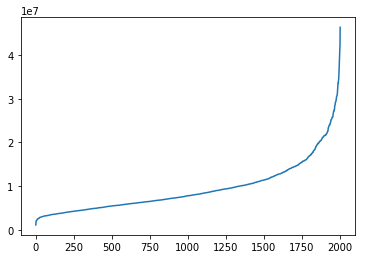

In [65]:
# plotting the original price column in the data.
combine_realstate["price"].plot()

Now, we wll plot the standardized price data, and  we can observe the range and the centre of the distribution for the standardised features. 

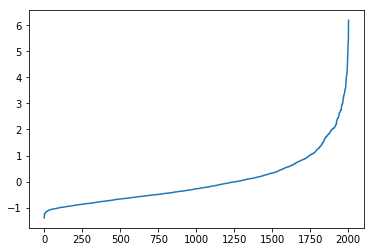

In [66]:
# plotting normalized price column in the data
combine_realstate["price_normalized"].plot()

From the above two plots, we can observe that both the plots are in same shape but are shifted. the scale of both the plots have changed. 

(<matplotlib.axes._subplots.AxesSubplot at 0x933510e908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x933510e908>)

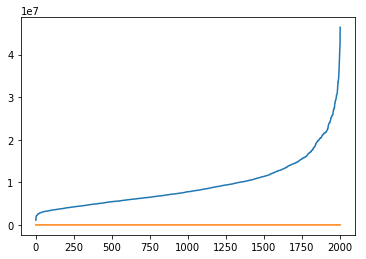

In [67]:
#plotting price and normalised price column 
combine_realstate["price"].plot(),combine_realstate["price_normalized"].plot()

### 5.2 MinMax Normalisation
Min-max normalisation is often known as feature scaling where the values of a numeric range of a feature of data are reduced to a scale between 0 and 1. Therefore, in order to calculate z, i.e. the normalised value of a member of the set of observed values of x, we must employ the following formula: z = (a - min(a) )/ (max(a) - min(a) , where min and max are the minimum and maximum values in x given its range.

Applying min-max normalisation on price attribute, we can observe that the minumum and maximum value of price attribute before min-max normalisation is 1108000 and 46410000 whereas after min-max normalisation it is 0 and 1.

In [68]:
#minmax normalisation on on price data
minmax_scale = preprocessing.MinMaxScaler().fit(combine_realstate[['price']])
df_minmax = minmax_scale.transform(combine_realstate[['price']])
df_minmax[0:5]

array([[0.        ],
       [0.01185378],
       [0.016688  ],
       [0.02140082],
       [0.02145601]])

In [69]:
#checking the maximum and minimum 
minA = combine_realstate.price.min()
maxA = combine_realstate.price.max()
minA, maxA

(1108000.0, 46410000.0)

In [70]:
#checking manually
a = combine_realstate.price[0] 
mma = (a - minA) / (maxA - minA)
mma

0.0

In [71]:
df_minmax[0][0]

0.0

In [72]:
#checking manually
a = combine_realstate[combine_realstate.price == combine_realstate.price.max()].price
mma = (a - minA) / (maxA - minA)
mma

2002    1.0
Name: price, dtype: float64

In [73]:
#Displaying the minimum and maximum value after min-max scaling
print('Min-value after min-max scaling:\nprice = {:.2f}'
      .format(df_minmax[:,0].min()))
print('\nMax-value after min-max scaling:\nprice = {:.2f}'
      .format(df_minmax[:,0].max()))

Min-value after min-max scaling:
price = 0.00

Max-value after min-max scaling:
price = 1.00


Plotting the price attribute before and after normalising.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000093351B83C8>]],
      dtype=object)

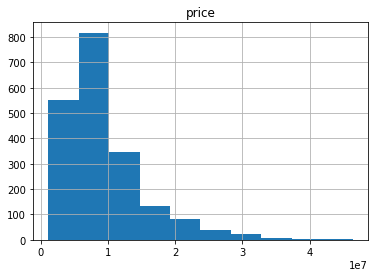

In [74]:
#plotting price data
combine_realstate.hist('price')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000933511A7F0>]],
      dtype=object)

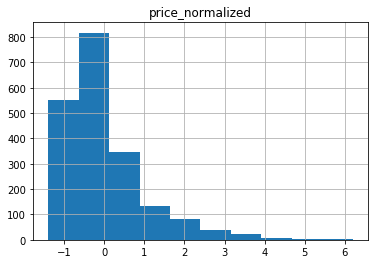

In [75]:
#plotting normalised price
combine_realstate.hist('price_normalized')

As we can observe from the above plots, the shape of the plot is same only the scaling of the plots have changed.

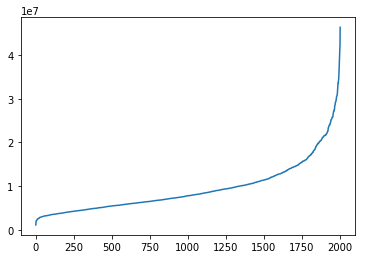

In [76]:
#line plot of price attribute
#plotting price before transformation
combine_realstate["price"].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000093363020F0>]],
      dtype=object)

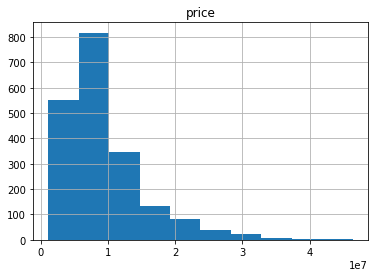

In [77]:
#plotting price before tranformation
combine_realstate.hist("price")

## 6. Transformation
Another way to reshape data is to perform data transformation. In Tukey's ladder of power, we will implement different kind of transformation and compare the following three kinds of transformations

* Root transformation
* Square power transformation
* Log transformation

### 6.1 Log Transformation
The log transformation can be used to make highly skewed distributions less skewed. This can be valuable for making patterns in the data more interpretable. Here, we will do log transformation on price attribute and observe the transformation.

In [78]:
# log transformation on price 
combine_realstate['price_log_transform'] = None
i = 0
for row in combine_realstate.iterrows():
    combine_realstate['price_log_transform'].at[i] = math.log(combine_realstate["price"][i])
    i += 1
    
combine_realstate.head()

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,price_normalized,price_log_transform
0,80076.0,-37.991583,145.178939,3 Locharn Crescent,KEYSBOROUGH,1108000.0,house,2009,3.0,1.0,0.0,SC_057,632,19889,1862,-1.396306,13.9181
1,48865.0,-37.813854,145.094833,1 Narrak Road,BALWYN,1645000.0,house,2008,3.0,2.0,2.0,SC_020,3051,19895,1037,-1.306339,14.3133
2,81680.0,-37.991203,145.236786,11 Cedar Street,DOVETON,1864000.0,house,2008,3.0,1.0,2.0,SC_077,1811,19888,3014,-1.269649,14.4382
3,9114.0,-37.875353,144.757768,52 Point Cook Road,SEABROOK,2077500.0,house,2013,4.0,2.0,2.0,SC_092,3616,19924,864,-1.233880,14.5467
4,45670.0,-37.677559,145.119329,3 Lightwood Lane,PLENTY,2080000.0,house,2016,4.0,3.0,2.0,SC_062,4445,19985,2707,-1.233462,14.5479


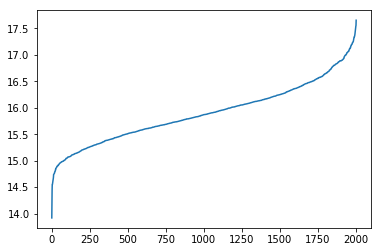

In [79]:
#plotting price after transformation
combine_realstate["price_log_transform"].plot()

### 6.2 Square power transformation

Square power transformation has moderate effect on distribution shape. It is weaker than the logarithm transformation. It is also used for reducing right skewness and also has the advantage that it can be applied to zero values. 

Here, we will do square power transformation on price attribute and observe the transformation.

In [80]:
#square power transformation on price data
combine_realstate['price_sq_transform'] = None
i = 0
for row in combine_realstate.iterrows():
    combine_realstate['price_sq_transform'].at[i] = math.pow(combine_realstate["price"][i],2)
    i += 1

    
combine_realstate.head()

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,price_normalized,price_log_transform,price_sq_transform
0,80076.0,-37.991583,145.178939,3 Locharn Crescent,KEYSBOROUGH,1108000.0,house,2009,3.0,1.0,0.0,SC_057,632,19889,1862,-1.396306,13.9181,1.22766e+12
1,48865.0,-37.813854,145.094833,1 Narrak Road,BALWYN,1645000.0,house,2008,3.0,2.0,2.0,SC_020,3051,19895,1037,-1.306339,14.3133,2.70602e+12
2,81680.0,-37.991203,145.236786,11 Cedar Street,DOVETON,1864000.0,house,2008,3.0,1.0,2.0,SC_077,1811,19888,3014,-1.269649,14.4382,3.4745e+12
3,9114.0,-37.875353,144.757768,52 Point Cook Road,SEABROOK,2077500.0,house,2013,4.0,2.0,2.0,SC_092,3616,19924,864,-1.233880,14.5467,4.31601e+12
4,45670.0,-37.677559,145.119329,3 Lightwood Lane,PLENTY,2080000.0,house,2016,4.0,3.0,2.0,SC_062,4445,19985,2707,-1.233462,14.5479,4.3264e+12


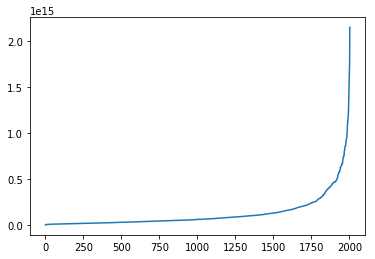

In [81]:
combine_realstate["price_sq_transform"].plot()

### 6.3 Root Transformation
Square root transformation has moderate effect on distribution shape. It is weaker than the logarithm transformation. It is also used for reducing right skewness and also has the advantage that it can be applied to zero values.

Here, we will do square root transformation on price attribute and observe the transformation.


In [82]:
#root transformation on price data
combine_realstate['price_root_transform'] = None
i = 0
for row in combine_realstate.iterrows():
    combine_realstate['price_root_transform'].at[i] = math.sqrt(combine_realstate["price"][i])
    i += 1

combine_realstate.head()

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,price_normalized,price_log_transform,price_sq_transform,price_root_transform
0,80076.0,-37.991583,145.178939,3 Locharn Crescent,KEYSBOROUGH,1108000.0,house,2009,3.0,1.0,0.0,SC_057,632,19889,1862,-1.396306,13.9181,1.22766e+12,1052.62
1,48865.0,-37.813854,145.094833,1 Narrak Road,BALWYN,1645000.0,house,2008,3.0,2.0,2.0,SC_020,3051,19895,1037,-1.306339,14.3133,2.70602e+12,1282.58
2,81680.0,-37.991203,145.236786,11 Cedar Street,DOVETON,1864000.0,house,2008,3.0,1.0,2.0,SC_077,1811,19888,3014,-1.269649,14.4382,3.4745e+12,1365.28
3,9114.0,-37.875353,144.757768,52 Point Cook Road,SEABROOK,2077500.0,house,2013,4.0,2.0,2.0,SC_092,3616,19924,864,-1.233880,14.5467,4.31601e+12,1441.35
4,45670.0,-37.677559,145.119329,3 Lightwood Lane,PLENTY,2080000.0,house,2016,4.0,3.0,2.0,SC_062,4445,19985,2707,-1.233462,14.5479,4.3264e+12,1442.22


In [83]:
#converting the transformed columns to float data type
combine_realstate[['price_log_transform','price_sq_transform','price_root_transform']] = combine_realstate[['price_log_transform','price_sq_transform','price_root_transform']].astype(float)

After plotting the square root transform price attribute, we can observe that the histogram is litte right skewed.

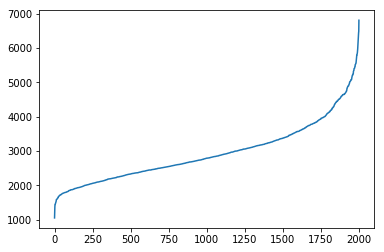

In [84]:
combine_realstate["price_root_transform"].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000093364B2B00>]],
      dtype=object)

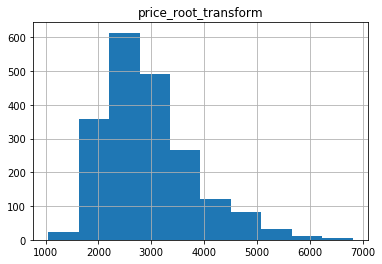

In [85]:
#plotting price after root transformation
combine_realstate.hist("price_root_transform")

After plotting price attribute after square power transformation, we can observe the histogram is right skewed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000093365D1048>]],
      dtype=object)

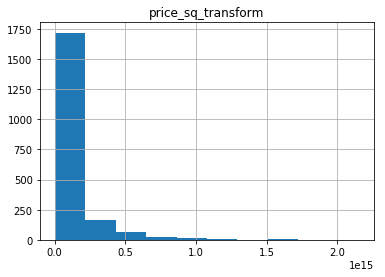

In [86]:
#plotting price after square power transformation
combine_realstate.hist("price_sq_transform")

By plotting the price attribute after log transformation we can observe that the histogram is normally distributed and even line plot is less skewed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000093365C1240>]],
      dtype=object)

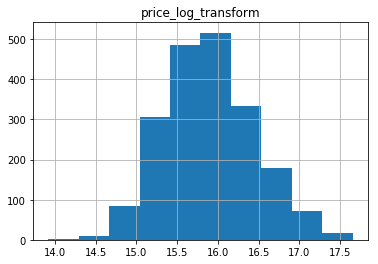

In [87]:
#plotting price after log transformation
combine_realstate.hist('price_log_transform')

#### From the above three transformations i.e log transformation, square power transformation and root transformation, we can observe that log transformation is the best transformation. Because it distributed the price attribute normally by removing right skewness and linearises the data.

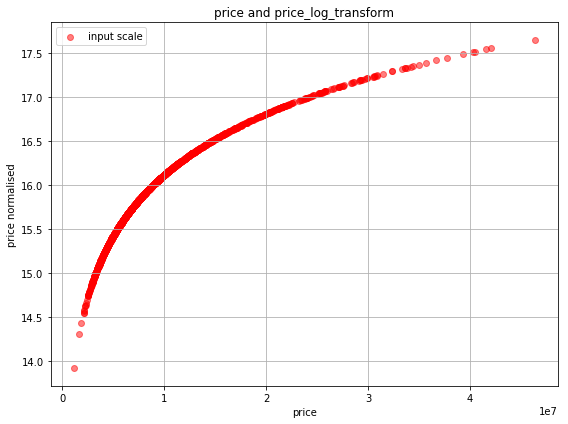

In [88]:
#plotting price vs log transform price
f = plt.figure(figsize=(8,6))
#plotting scatter plot
plt.scatter(combine_realstate['price'], combine_realstate['price_log_transform'],
            color='red', label='input scale', alpha=0.5)
#title 
plt.title('price and price_log_transform')
#X-label
plt.xlabel('price')
#Y-label
plt.ylabel('price normalised')

plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

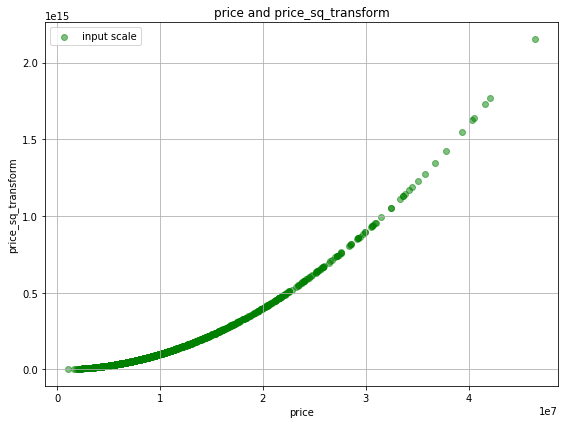

In [89]:
#plotting price vs square power transform price
f = plt.figure(figsize=(8,6))
plt.scatter(combine_realstate['price'], combine_realstate['price_sq_transform'],
            color='green', label='input scale', alpha=0.5)
plt.title('price and price_sq_transform')
plt.xlabel('price')
plt.ylabel('price_sq_transform')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

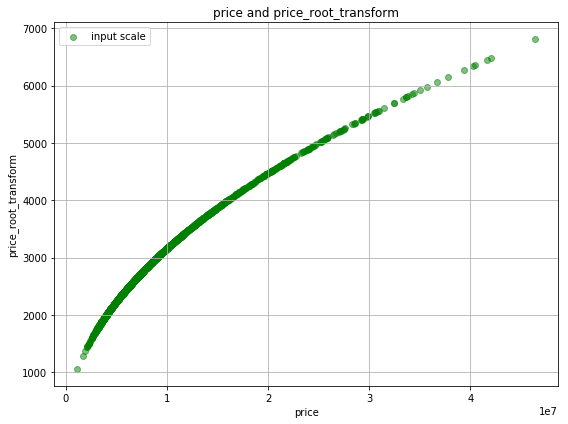

In [90]:
#plotting price vs root transform price
f = plt.figure(figsize=(8,6))
plt.scatter(combine_realstate['price'], combine_realstate['price_root_transform'],
            color='green', label='input scale', alpha=0.5)
plt.title('price and price_root_transform')
plt.xlabel('price')
plt.ylabel('price_root_transform')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

### Linear Model

In [91]:
# Seaborn visualization library
import seaborn as sns


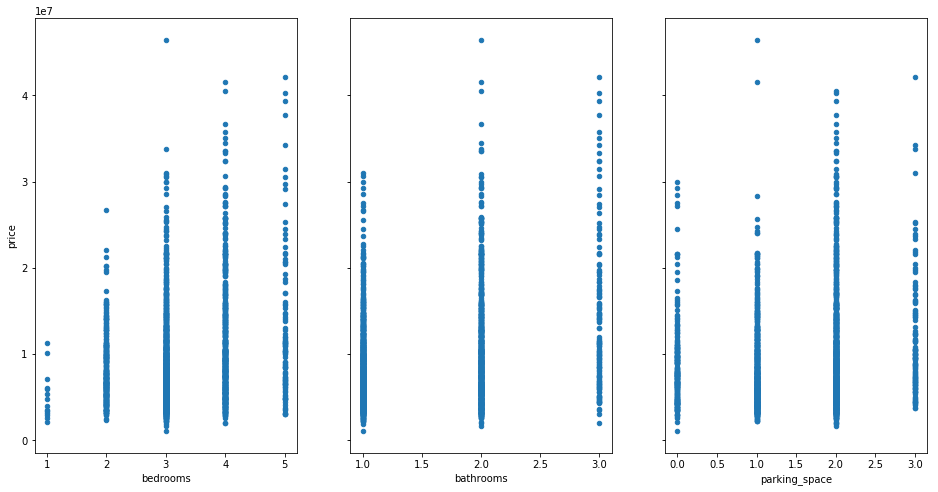

In [92]:
# visualizing the relationship between the different features and the response variable price using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)
combine_realstate.plot(kind='scatter', x='bedrooms', y='price', ax=axs[0], figsize=(16, 8))
combine_realstate.plot(kind='scatter', x='bathrooms', y='price', ax=axs[1])
combine_realstate.plot(kind='scatter', x='parking_space', y='price', ax=axs[2])


In [93]:
import scipy.stats as stats
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [94]:
#linear model between predictor attributes property type, bedroom, bathroom, parking space and response is price
combine_realstate["property_type"] = 1
x=combine_realstate[combine_realstate.columns[[6,8,9,10]]]
y=combine_realstate["price"]
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state = 1)
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_test, y_test))

model =sm.OLS(y,x).fit()
predict=model.predict(x)
summary_m=model.summary()
print(summary_m)

0.07984213046825761
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     62.27
Date:                Sun, 28 Oct 2018   Prob (F-statistic):           1.75e-38
Time:                        15:26:10   Log-Likelihood:                -34004.
No. Observations:                2003   AIC:                         6.802e+04
Df Residuals:                    1999   BIC:                         6.804e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
property_type  3.322e+06  

In [95]:
#linear model between predictor attributes property type, bedroom, bathroom, parking space and response is price_normalized
combine_realstate["property_type"] = 1
x=combine_realstate[combine_realstate.columns[[6,8,9,10]]]
y=combine_realstate["price_normalized"]
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state = 1)
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_test, y_test))

model =sm.OLS(y,x).fit()
predict=model.predict(x)
summary_m=model.summary()
print(summary_m)

0.07984213046825761
                            OLS Regression Results                            
Dep. Variable:       price_normalized   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     62.27
Date:                Sun, 28 Oct 2018   Prob (F-statistic):           1.75e-38
Time:                        15:26:11   Log-Likelihood:                -2752.7
No. Observations:                2003   AIC:                             5513.
Df Residuals:                    1999   BIC:                             5536.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
property_type    -1.0254  

In [96]:
#linear model between predictor attributes property type, bedroom, bathroom, parking space and response is price_log_transform
combine_realstate["property_type"] = 1
x=combine_realstate[combine_realstate.columns[[6,8,9,10]]]
y=combine_realstate["price_log_transform"]
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state = 1)
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_test, y_test))

model =sm.OLS(y,x).fit()
predict=model.predict(x)
summary_m=model.summary()
print(summary_m)

0.07203966488678415
                             OLS Regression Results                            
Dep. Variable:     price_log_transform   R-squared:                       0.069
Model:                             OLS   Adj. R-squared:                  0.068
Method:                  Least Squares   F-statistic:                     49.41
Date:                 Sun, 28 Oct 2018   Prob (F-statistic):           8.35e-31
Time:                         15:26:12   Log-Likelihood:                -1592.2
No. Observations:                 2003   AIC:                             3192.
Df Residuals:                     1999   BIC:                             3215.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
property_type   

In [97]:
#linear model between predictor attributes property type, bedroom, bathroom, parking space and response is price_sq_transform
combine_realstate["property_type"] = 1
x=combine_realstate[combine_realstate.columns[[6,8,9,10]]]
y=combine_realstate["price_sq_transform"]
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state = 1)
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_test, y_test))

model =sm.OLS(y,x).fit()
predict=model.predict(x)
summary_m=model.summary()
print(summary_m)

0.06875246837082993
                            OLS Regression Results                            
Dep. Variable:     price_sq_transform   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     57.79
Date:                Sun, 28 Oct 2018   Prob (F-statistic):           8.02e-36
Time:                        15:26:13   Log-Likelihood:                -68631.
No. Observations:                2003   AIC:                         1.373e+05
Df Residuals:                    1999   BIC:                         1.373e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
property_type -6.361e+13  

In [98]:
#linear model between predictor attributes property type, bedroom, bathroom, parking space and response is price_root_transform
combine_realstate["property_type"] = 1
x=combine_realstate[combine_realstate.columns[[6,8,9,10]]]
y=combine_realstate["price_root_transform"]
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state = 1)
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_test, y_test))

model =sm.OLS(y,x).fit()
predict=model.predict(x)
summary_m=model.summary()
print(summary_m)

0.07883306906759835
                             OLS Regression Results                             
Dep. Variable:     price_root_transform   R-squared:                       0.080
Model:                              OLS   Adj. R-squared:                  0.078
Method:                   Least Squares   F-statistic:                     57.72
Date:                  Sun, 28 Oct 2018   Prob (F-statistic):           8.78e-36
Time:                          15:26:14   Log-Likelihood:                -16300.
No. Observations:                  2003   AIC:                         3.261e+04
Df Residuals:                      1999   BIC:                         3.263e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
proper

R2 is a statistic that will give some information about the goodness of fit of a model. In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.

From the above linear models, we can conclude that price normalised data explains much better about the data as the R0square value is 85% . 

# Reference:
1.  week 9 tutorial
2. week 10 tutorial
3. week 11 tutorial
4. http://www.austintaylor.io/lxml/python/pandas/xml/dataframe/2016/07/08/convert-xml-to-pandas-dataframe/
5. https://www.analyticsvidhya.com/blog/2017/03/read-commonly-used-formats-using-python/
6. http://howto.commetrics.com/methodology/statistics/normalization/
7. https://www.quora.com/What-is-the-meaning-of-min-max-normalization
8. http://onlinestatbook.com/2/transformations/log.html
9. http://fmwww.bc.edu/repec/bocode/t/transint.html
